# **Classificação de estrelas, quasares e galáxias**

Nosso [dataset](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) contém características espectrais de três objetos celestes: estrelas, quasares e galáxias. O dados são obtidos de observações da Sloan Digital Sky Survey.

## **Sobre os dados**

Começamos carregando o conjunto de dados.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/stars/star_classification.csv.zip')
print(df.shape)
df.head()

Mounted at /content/gdrive
(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


São $100\,000$ objetos na base de dados, com $17$ colunas de características fotométricas e de identificação, e uma coluna que rotula a classe a qual cada objeto pertence. A coluna `obj_ID`contém números de identificação de cada objeto e podemos usá-lo de índice (ou alternativamente descartar a coluna).

In [2]:
df.drop(columns ='obj_ID', inplace = True)

Vamos verificar a existência de valores nulos no dataframe.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   alpha        100000 non-null  float64
 1   delta        100000 non-null  float64
 2   u            100000 non-null  float64
 3   g            100000 non-null  float64
 4   r            100000 non-null  float64
 5   i            100000 non-null  float64
 6   z            100000 non-null  float64
 7   run_ID       100000 non-null  int64  
 8   rerun_ID     100000 non-null  int64  
 9   cam_col      100000 non-null  int64  
 10  field_ID     100000 non-null  int64  
 11  spec_obj_ID  100000 non-null  float64
 12  class        100000 non-null  object 
 13  redshift     100000 non-null  float64
 14  plate        100000 non-null  int64  
 15  MJD          100000 non-null  int64  
 16  fiber_ID     100000 non-null  int64  
dtypes: float64(9), int64(7), object(1)
memory usage: 13.0+ MB


Percebemos que todas as células estão preenchidas, portanto não será necessário preencher valores nulos.

Notamos, porém, que há outliers que deverão ser tratados:

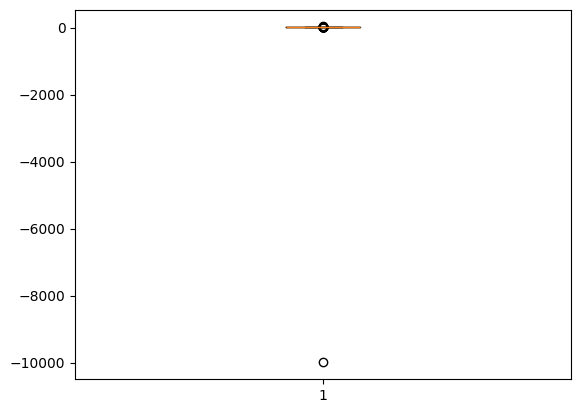

In [4]:
plt.boxplot(df['u'])
plt.show()

In [5]:
df = df[df['u'] > -2000]

Outra modificação que será importante para o nosso problema de clusterização é separar as colunas numéricas e a classe a que cada objeto pertence. Os valores das classes serão usados para a avaliação do modelo mais adiante.

In [6]:
y = df['class']
X = df.drop(columns = 'class')

Para entender mais sobre nossos dados, vamos observar a proporção de elementos de cada classe.

In [7]:
y.value_counts()

,count
class,
GALAXY,59445
STAR,21593
QSO,18961


Percebemos que mais da metade dos dados se encontram na classe `GALAXY`. Isso pode ter algum impacto na densidade dos dados. Veremos como isso afeta o comportameto dos clusters mais a frente.

## **Visualização com t-SNE**

Nosso próximo passo é usar o t-SNE para visualizar a distribuição dos dados em duas dimensões.

In [8]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, init = 'random', perplexity = 20)
X_tsne = tsne.fit_transform(X_scaled[:5000])

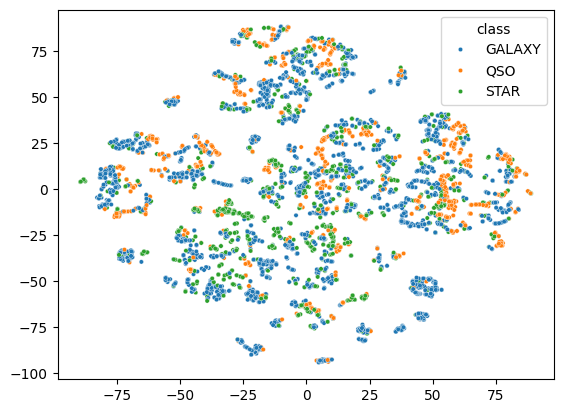

In [9]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y[:5000], s = 10)
plt.show()

O algoritmo t-SNE parece pouco capaz de agrupar os dados de acordo com as classes.

## **Clusterização sem redução de dimensionalidade**

Podemos utilizar o algoritmo k-means para agrupar os objetos em três grupos distintos:


In [64]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import rand_score

def cluster_kmeans(X, n_clusters):
     kmeans = KMeans(n_clusters=n_clusters)
     kmeans.fit(X)
     y_kmeans = kmeans.predict(X)
     return y_kmeans

def cluster_agglomerative(X, n_clusters):
     agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
     agglomerative.fit(X)
     return agglomerative.labels_

def avaliar_clustering_externo(labels, true_labels):
    rand = rand_score(labels, true_labels)
    return rand

In [11]:
kmeans = cluster_kmeans(X_scaled, 3)
print(f'Rand index KMeans: {avaliar_clustering_externo(kmeans, y)}')

Rand index KMeans: 0.5228855408616487


## **Clusterização com redução de dimensionalidade**

Vamos usar o PCA para reduzir a de dimensionalidade dos dados, a fim de melhorar a execução do algoritmo de clusterização dos dados.

Text(0, 0.5, '$f(k)$ - Fração cumulativa da variância explicada')

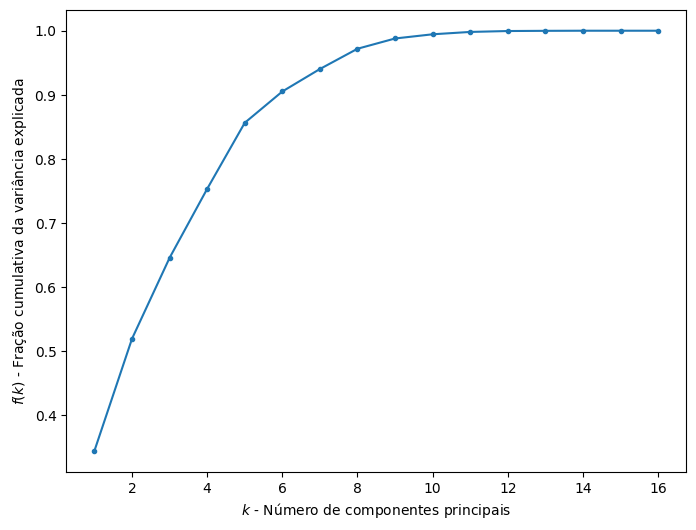

In [12]:
from sklearn.decomposition import PCA

pca_all = PCA(n_components=16)
pca_all.fit(X_scaled)
fig = plt.figure(figsize=(8, 6))
plt.plot([i for i in range(1, pca_all.n_components + 1)], np.cumsum(pca_all.explained_variance_ratio_), ".-")
plt.xlabel('$k$ - Número de componentes principais')
plt.ylabel('$f(k)$ - Fração cumulativa da variância explicada')

Com $6$ componentes já é possível explicar quase $90\%$ da variância dos dados. A partir de $10$ componentes, quase nenhuma informação é adicionada.

In [13]:
pca = PCA(n_components = 6)
X_reduz = pca.fit_transform(X_scaled)

In [14]:
y_kmeans = cluster_kmeans(X_reduz, 3)
print(f'Rand index KMeans: {avaliar_clustering_externo(y_kmeans, y)}')

Rand index KMeans: 0.532788963162337


O `rand index` mostra que a clusterização com redução de dimensionalidade não obteve resultados melhores. Nosso objetivo então será melhorar a escolha de features, para que reflitam uma maior diferenciação entre as classes.

## **Seleção de features usando clusterização hierárquica**

O nosso objetivo nessa seção é utilizar clusterização hierárquica _nas features_ para agrupar características semelhantes. Dessa forma, poderemos escolher uma feature mais importante em cada um dos grupos, e refinar nossa análise.

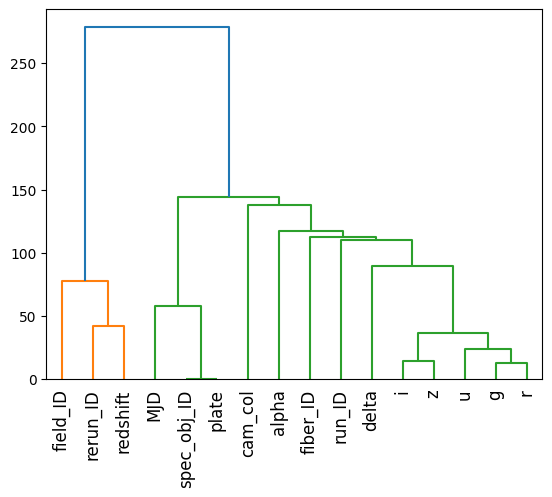

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

X_transposed = X_scaled.transpose()
linked = linkage(X_transposed, 'ward')
dendrogram(linked, labels = X.transpose().index)
plt.xticks(rotation=90)
plt.show()

O dendograma nos mostra a flexibilidade no número de clusters que queremos ter. No nosso caso, organizaremos nossas features em $2$ clusters para fazer a visualização dos dados novamente.

In [16]:
num_cluster = 2
labels = fcluster(linked, num_cluster, criterion='maxclust')
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2], dtype=int32)

Selecionamos uma feature de cada cluster para obter uma lista de três features mais importantes. Faremos isso usando uma medida de correlação entre features e `class`.

In [17]:
class_mapping = {'GALAXY': 0, 'STAR': 1, 'QSO': 2}
df['class_numeric'] = df['class'].map(class_mapping)
correlation = []
for col in X.columns:
  corr = df['class_numeric'].corr(X[col])
  correlation.append(corr)

df_cluster = pd.DataFrame(list(zip(X.columns, labels, correlation)), columns=['feature', 'cluster', 'correlation'])
df_cluster['abs_corr'] = abs(df_cluster['correlation'])

features = []
cluster = [0]*num_cluster
for i in range(0, num_cluster):
    cluster[i] = df_cluster[df_cluster['cluster'] == i+1]
    max_cluster = cluster[i].loc[cluster[i]['abs_corr'].idxmax()]['feature']
    features.append(max_cluster)

X_new = X[features]

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Acabamos de realizar a seleção de features, e agora plotamos os dados.

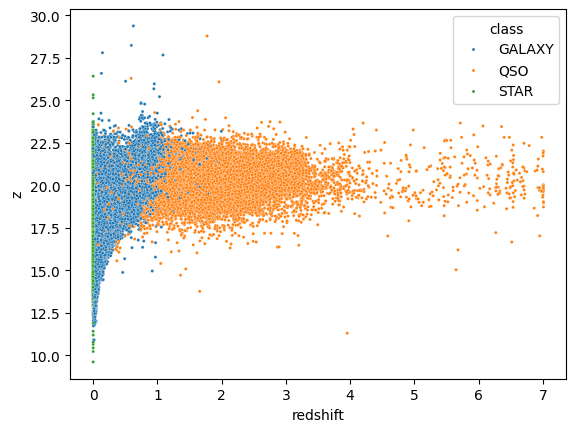

In [18]:
sns.scatterplot(x=X_new.iloc[:,0], y=X_new.iloc[:,1], hue = y, s = 5)
plt.show()

E podemos ver uma separação muito mais clara das classes.

Agora fazemos a clusterização novamente para avaliar os resultados.

In [34]:
X_new_scaled = scaler.fit_transform(X_new)
KMeans = cluster_kmeans(X_new_scaled[:10000], 3)
print(f'Rand index KMeans: {avaliar_clustering_externo(KMeans, y[:10000])}')

Rand index KMeans: 0.6020169816981699


Percebemos que o `rand index` aumentou em relação às duas aplicações anteriores do k-means.

In [35]:
Agglomerative = cluster_agglomerative(X_new_scaled[:10000], 3)
print(f'Rand index Agglomerative: {avaliar_clustering_externo(Agglomerative, y[:10000])}')

Rand index Agglomerative: 0.5598840684068407


As classificações de cada algoritmo são visualizadas abaixo.

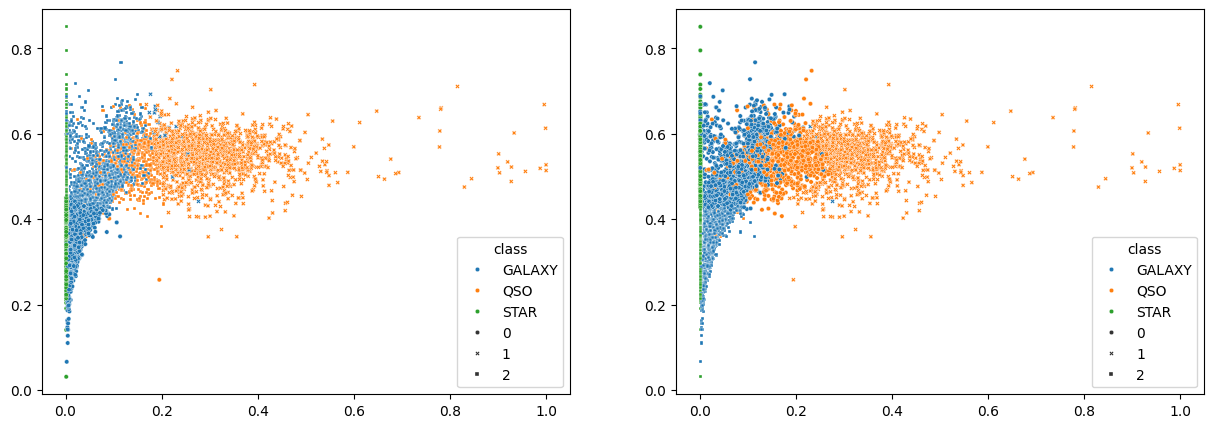

In [63]:
alg = [KMeans, Agglomerative]
figure, axis = plt.subplots(1, 2, figsize=(15,5))
for i in range(len(alg)):
  axis[i] = sns.scatterplot(x=X_new_scaled[:10000,0], y=X_new_scaled[:10000,1], hue = y[:10000], style = alg[i], s = 10, ax = axis[i])
plt.show()